# Pet Classification

**Learning Materials**  
https://medium.com/one-minute-machine-learning/clip-paper-explained-easily-in-3-levels-of-detail-61959814ad13  
  
https://towardsdatascience.com/clip-the-most-influential-ai-model-from-openai-and-how-to-use-it-f8ee408958b1

In [ ]:
# python. torch, deep learning, computer vision, CLIP - zero shot, CLIP - linear probe, KNN, ResNet, Vit,

# 1. Prepare data

In [ ]:
import json
import os
import os.path as osp
import numpy as np
import pandas as pd
import torch
%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from torch.utils.data import DataLoader

## 1.1 Load the dataset

In [ ]:
# Download to folder "CLIP"
def download_pet_images(directory=r"C:\Users\mark7\Project\DP_LLM", img_transform = None):
    if os.path.isdir(directory + "IIIT-pets"):
        do_download = False
    else:
        do_download = True

    train_set = OxfordIIITPet(root=directory, split = 'trainval', transform = img_transform, download=do_download)
    test_set = OxfordIIITPet(root=directory, split = 'test', transform = img_transform, download=do_download)

    return train_set, test_set

In [ ]:
pet_train, pet_test = download_pet_images()
print(len(pet_train))
print(len(pet_test))

3680
3669


In [ ]:
pet_train[0]

(<PIL.Image.Image image mode=RGB size=394x500>, 0)

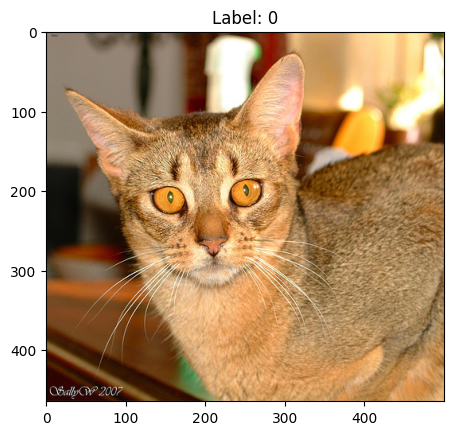

In [ ]:
# example 3
image, label = pet_train[2]
image_array = np.array(image)

plt.imshow(image_array)
plt.title(f"Label: {label}")
plt.show()

## 1.2 Read labels
The structure of labels:
* Image CLASS-ID SPECIES BREED ID
* ID: 1:37 Class ids
* SPECIES: 1:Cat 2:Dog
* BREED ID: 1-25:Cat 1:12:Dog
* All images with 1st letter as captial are cat images
* images with small first letter are dog images

In [ ]:
# read labels
def get_labels(file = "trainval.txt"):
  directory = r"C:\Users\mark7\Project\DP_LLM\oxford-iiit-pet\annotations"
  curr_directory = os.path.join(directory, file)
  print(curr_directory)
  df = pd.read_csv(curr_directory, sep=' ', header=None, names=['name_id', 'Class', 'Species', 'Breed'])
  return df

In [ ]:
# labels of trainval dataset
trainval_labels = get_labels()
trainval_labels.head()

C:\Users\mark7\Project\DP_LLM\oxford-iiit-pet\annotations\trainval.txt


,name_id,Class,Species,Breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [ ]:
# labels of test dataset
test_labels = get_labels("test.txt")
test_labels.head()

C:\Users\mark7\Project\DP_LLM\oxford-iiit-pet\annotations\test.txt


,name_id,Class,Species,Breed
0,Abyssinian_201,1,1,1
1,Abyssinian_202,1,1,1
2,Abyssinian_204,1,1,1
3,Abyssinian_205,1,1,1
4,Abyssinian_206,1,1,1


In [ ]:
pet_train.classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

## 1.3 Concat labels to images

### Current Data Structure:  
```
pet_train[n][0] -> the n-th train IMAGE  
pet_train[n][1] -> the n-th train LABEL (just 0:car or 1:dog)  
pet_test[n][0] -> the n-th test IMAGE  
pet_test[n][1] -> the n-th teat LABEL  (just 0:car or 1:dog)  
pet_classes[k] -> the name of the K-th CLASS
```
But I want pet_train[n][1] and pet_test[n][1] to be **classes_ids**

In [ ]:
pet_classes = pet_train.classes

In [ ]:
# Class start with 1
trainval_labels['Class'][0:3]

0    1
1    1
2    1
Name: Class, dtype: int64

In [ ]:
from tqdm import tqdm

def update_labels(pet_dataset, labels_df):
    updated_dataset = []

    # Use tqdm to create a progress bar
    for n in tqdm(range(len(pet_dataset)), desc="Updating Labels"):
        # change it to start with 0
        updated_dataset.append((pet_dataset[n][0], labels_df['Class'][n] - 1))

    return updated_dataset

# Call the function with your pet_train dataset and trainval_labels DataFrame
pet_train_updated = update_labels(pet_train, trainval_labels)

Updating Labels: 100%|████████████████████████████████████████████████████████████| 3680/3680 [00:15<00:00, 245.33it/s]


In [ ]:
# Call the function with your pet_train dataset and trainval_labels DataFrame
pet_test_updated = update_labels(pet_test, test_labels)

Updating Labels: 100%|████████████████████████████████████████████████████████████| 3669/3669 [00:15<00:00, 235.33it/s]


In [ ]:
pet_train_updated[5]

(<PIL.Image.Image image mode=RGB size=500x375>, 0)

In [ ]:
pet_train_updated[-5]

(<PIL.Image.Image image mode=RGB size=500x334>, 36)

In [ ]:
pet_test_updated[5]

(<PIL.Image.Image image mode=RGB size=208x278>, 0)

In [ ]:
pet_test_updated[-5]

(<PIL.Image.Image image mode=RGB size=500x335>, 36)

# 2. Prepare CLIP Model


**CLIP - Constrastive Language-Image Pretraining for Vision**  
* CLIP involves two encoders: Image encoder & Text encoder  
* During training, the images and captions in a mini-batch are transformed to vectors of the same length by their corresponding encoders.  
* After normalization, the image vectors are pulled closer to their corresponding text vectors, and pulled apart from the other text vectors.

We use ViT-B/32 and RN50 as our image encoder.

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\mark7\appdata\local\temp\pip-req-build-dnru3gje
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\mark7\AppData\Local\Temp\pip-req-build-dnru3gje'

[notice] A new release of pip is available: 23.3 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import clip

In [ ]:
# set device to "cuda" to call the GPU
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device = device)

In [ ]:
clip_model_2, clip_preprocess_2 = clip.load("RN50", device = device)

## 2.1 CLIP zero-shot prediction

Ground truth: German Shorthaired

Top predictions:

German Shorthaired: 98.03%
  English Setter: 1.57%
English Cocker Spaniel: 0.32%
    Basset Hound: 0.04%
          Bombay: 0.02%


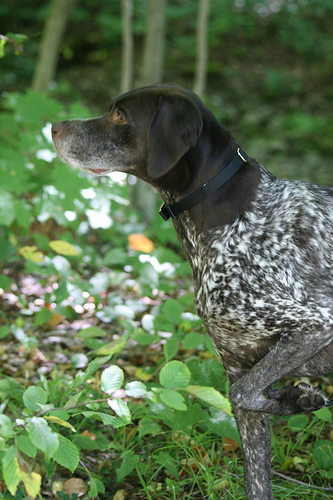

In [ ]:
# An example for the result

# Prepare the inputs
n = 718
image, class_id = pet_train_updated[n]
image_input = clip_preprocess(image).unsqueeze(0).to(device) # extract image and put in device memory
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}, a type of pet.") for c in pet_classes]).to(device) # put text to match to image in device memory

# Calculate features
with torch.no_grad():
    image_features = clip_model.encode_image(image_input) # compute image features with CLIP model
    text_features = clip_model.encode_text(text_inputs) # compute text features with CLIP model
image_features /= image_features.norm(dim=-1, keepdim=True) # unit-normalize image features
text_features /= text_features.norm(dim=-1, keepdim=True) # unit-normalize text features

# Pick the top 5 most similar labels for the image
similarity = (100.0 * image_features @ text_features.T) # score is cosine similarity times 100
p_class_given_image= similarity.softmax(dim=-1)  # P(y|x) is score through softmax
values, indices = p_class_given_image[0].topk(5) # gets the top 5 labels

# Print the probability of the top five labels
print("Ground truth:", pet_classes[class_id])
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{pet_classes[index]:>16s}: {100 * value.item():.2f}%")
image

In [ ]:
pet_train

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: C:\Users\mark7\Project\DP_LLM

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
pet_train_trans_1, pet_test_trans_1 = download_pet_images(img_transform = clip_preprocess)

In [ ]:
pet_train_final_1 = update_labels(pet_train_trans_1, trainval_labels)

Updating Labels: 100%|████████████████████████████████████████████████████████████| 3680/3680 [00:30<00:00, 120.83it/s]


In [ ]:
pet_test_final_1 = update_labels(pet_test_trans_1, test_labels)

Updating Labels: 100%|████████████████████████████████████████████████████████████| 3669/3669 [00:28<00:00, 129.93it/s]


In [ ]:
pet_train_trans_2, pet_test_trans_2 = download_pet_images(img_transform = clip_preprocess_2)

In [ ]:
pet_train_final_2 = update_labels(pet_train_trans_2, trainval_labels)

Updating Labels: 100%|████████████████████████████████████████████████████████████| 3680/3680 [00:28<00:00, 127.99it/s]


In [ ]:
pet_test_final_2 = update_labels(pet_test_trans_2, test_labels)

Updating Labels: 100%|████████████████████████████████████████████████████████████| 3669/3669 [00:27<00:00, 132.14it/s]


In [ ]:
# try 2 image encoders, vit and resnet
def clip_zero_shot(data_set, classes, encoder = clip_model):
    data_loader = DataLoader(data_set, batch_size=64, shuffle=False)

    correct_pred = 0
    total_pred = 0

    with torch.no_grad(): #  disables gradient computation
      for images, labels in tqdm(data_loader):
        images_input = images.to(device)
        text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}, a type of flower.") for c in classes]).to(device)

        image_features = encoder.encode_image(images_input) # compute with CLIP model
        text_features = encoder.encode_text(text_inputs)
        image_features /= image_features.norm(dim = -1, keepdim = True) # unit-normalize
        text_features /= text_features.norm(dim = -1, keepdim = True)

        similarities = (100.0 * image_features @ text_features.T) # cosine similarity times 100
        p_class_given_image = similarities.softmax(dim = -1)
        value, index = p_class_given_image.topk(1) # pick the top1
        predicted = index.squeeze(1)

        correct_pred += (predicted == labels.to(device)).sum().item()
        total_pred += len(labels)
    accuracy = correct_pred / total_pred
    return accuracy

In [ ]:
# ViT-B/32
accuracy_1 = clip_zero_shot(data_set=pet_test_final_1, classes=pet_classes)
print(f"\nAccuracy = {100*accuracy_1:.3f}%")

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [07:24<00:00,  7.66s/it]


Accuracy = 79.013%


In [ ]:
# RN50
accuracy_2 = clip_zero_shot(data_set=pet_test_final_2, classes=pet_classes, encoder = clip_model_2)
print(f"\nAccuracy = {100*accuracy_2:.3f}%")

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [08:58<00:00,  9.28s/it]


Accuracy = 75.906%


## 2.2 CLIP linear probe prediction

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
def get_features(data_set, encoder = clip_model):
    # Needs code here
    data_loader = DataLoader(data_set, batch_size=64, shuffle=False)  # dataloader lets you process in batch which is way faster
    image_features = []
    labels = []

    # Extract CLIP features for each image in the dataset
    for images, labels_batch in data_loader:
      # Move images to the device where the model is located
      images = images.to(device)

      # Extract CLIP features for the images
      with torch.no_grad():
        features = encoder.encode_image(images)

      # Append the features and labels to the lists
      image_features.append(features.cpu().numpy())
      labels.append(labels_batch.numpy())

   # Concatenate the features and labels into numpy arrays
    image_features = np.concatenate(image_features)
    labels = np.concatenate(labels)

    return image_features, labels

In [ ]:
# Calculate the image features
train_features, train_labels = get_features(pet_train_final_1)
test_features, test_labels = get_features(pet_test_final_1)

In [ ]:
# Perform logistic regression
clf = LogisticRegression(random_state=0,  max_iter=500)
clf.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
accuracy_3 = clf.score(test_features, test_labels)
print(f"\nAccuracy = {100*accuracy_3:.3f}%")


Accuracy = 89.043%


In [ ]:
# Calculate the image features
train_features_2, train_labels_2 = get_features(pet_train_final_2, encoder = clip_model_2)
test_features_2, test_labels_2 = get_features(pet_test_final_2, encoder = clip_model_2)

In [ ]:
# Perform logistic regression
clf = LogisticRegression(random_state=0,  max_iter=500)
clf.fit(train_features_2, train_labels_2)

# Evaluate using the logistic regression classifier
accuracy_4 = clf.score(test_features_2, test_labels_2)
print(f"\nAccuracy = {100*accuracy_4:.3f}%")


Accuracy = 85.718%


In [ ]:
from PIL import Image
image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

In [ ]:
from PIL import Image
# Samoyed: 82.61%
image_path = r"C:\Users\mark7\Project\DP_LLM\smalldog.png"
image_try = Image.open(image_path)

In [ ]:
from PIL import Image
# Bombay: 37.39% Samoyed: 20.55%
image_path = r"C:\Users\mark7\Project\DP_LLM\bigdog.png"
image_try = Image.open(image_path)

Ground truth: American Pit Bull Terrier

Top predictions:

         Samoyed: 82.61%
        Keeshond: 6.27%
  Great Pyrenees: 3.46%
    Newfoundland: 2.44%
      Pomeranian: 1.90%


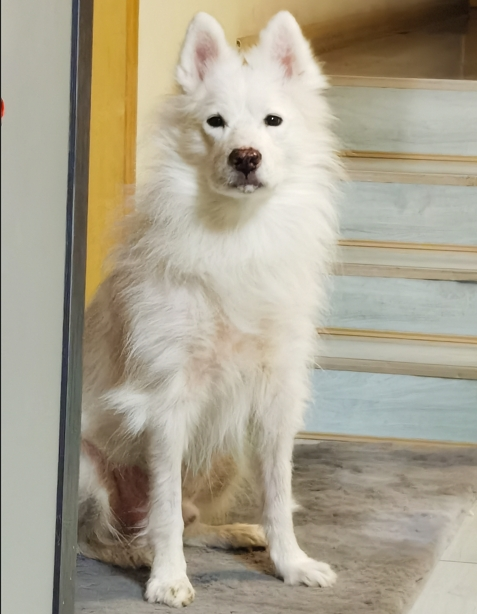

In [ ]:
# An example for the result

# Prepare the inputs
n = 718
image, class_id = image_try,2
image_input = clip_preprocess(image).unsqueeze(0).to(device) # extract image and put in device memory
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}, a type of pet.") for c in pet_classes]).to(device) # put text to match to image in device memory

# Calculate features
with torch.no_grad():
    image_features = clip_model.encode_image(image_input) # compute image features with CLIP model
    text_features = clip_model.encode_text(text_inputs) # compute text features with CLIP model
image_features /= image_features.norm(dim=-1, keepdim=True) # unit-normalize image features
text_features /= text_features.norm(dim=-1, keepdim=True) # unit-normalize text features

# Pick the top 5 most similar labels for the image
similarity = (100.0 * image_features @ text_features.T) # score is cosine similarity times 100
p_class_given_image= similarity.softmax(dim=-1)  # P(y|x) is score through softmax
values, indices = p_class_given_image[0].topk(5) # gets the top 5 labels

# Print the probability of the top five labels
print("Ground truth:", pet_classes[class_id])
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{pet_classes[index]:>16s}: {100 * value.item():.2f}%")
image

In [ ]:
# Calculate the image features
train_features, train_labels = get_features(pet_train_final_1)
test_features, test_labels = get_features(pet_test_final_1)

# Perform logistic regression
clf = LogisticRegression(random_state=0,  max_iter=500)
clf.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
accuracy_3 = clf.score(test_features, test_labels)
print(f"\nAccuracy = {100*accuracy_3:.3f}%")


Accuracy = 89.043%


# 3. Nearest-neighbor classifier on CLIP features
record features of training examples and use K-NN classifier

In [ ]:
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## 3.1 Tune ViT

In [ ]:
k = 1
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(train_features, train_labels)
y_pred = clf.predict(test_features)
accuracy_5 = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy_5)

Accuracy: 0.7086399563913873


In [ ]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(train_features, train_labels)
y_pred = clf.predict(test_features)
accuracy_6 = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy_6)

Accuracy: 0.7337149086944672


In [ ]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(train_features, train_labels)
y_pred = clf.predict(test_features)
accuracy_7 = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy_7)

Accuracy: 0.7514309076042518


In [ ]:
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(train_features, train_labels)
y_pred = clf.predict(test_features)
accuracy_8 = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy_8)

Accuracy: 0.7661488143908421


## 3.2 Tune RN

In [ ]:
k = 1
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(train_features_2, train_labels_2)
y_pred = clf.predict(test_features_2)
accuracy_9 = accuracy_score(test_labels_2, y_pred)
print("Accuracy:", accuracy_9)

Accuracy: 0.6437721449986372


In [ ]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(train_features_2, train_labels_2)
y_pred = clf.predict(test_features_2)
accuracy_10 = accuracy_score(test_labels_2, y_pred)
print("Accuracy:", accuracy_10)

Accuracy: 0.6541291905151267


In [ ]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(train_features_2, train_labels_2)
y_pred = clf.predict(test_features_2)
accuracy_11 = accuracy_score(test_labels_2, y_pred)
print("Accuracy:", accuracy_11)

Accuracy: 0.6827473426001636


In [ ]:
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(train_features_2, train_labels_2)
y_pred = clf.predict(test_features_2)
accuracy_12 = accuracy_score(test_labels_2, y_pred)
print("Accuracy:", accuracy_12)

Accuracy: 0.6884709730171709


In [ ]:
data = {
    'top-1 accuracy': ['CLIP - zero shot', 'CLIP - linear probe', 'KNN - use CLIP features'],
    'ViT-B/32': [accuracy_1, accuracy_3, accuracy_8],
    'RN50': [accuracy_2, accuracy_4, accuracy_12]
}

# Creating a DataFrame from the dictionary
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

            top-1 accuracy  ViT-B/32      RN50
0         CLIP - zero shot  0.790134  0.759062
1      CLIP - linear probe  0.890433  0.857182
2  KNN - use CLIP features  0.766149  0.688471
